# Исследование данных о продажах компьютерных игр

В нашем распоряжении данные интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Имеем исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


## Откроем файл с данными и изучим общую информацию.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from scipy import stats as st
#подключаем необходимые библиотеки

In [ ]:
df = pd.read_csv('/datasets/games.csv')
df.info() #выводим общую информацию
df.head(5) #выводим первые пять строк таблицы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Необходимо привести названия столбцов к нижнему регистру для удобства работы, а также поменять типы данных столбцам Year_of_Release - interger (годы должны быть целыми числами), User_Score - float (приведем к числовому формату). Проверим на пропуски и дубликаты.

## Подготовим данные

### Заменим названия столбцов

In [ ]:
df.columns = df.columns.str.lower() #приведем все названия столбцов к нижнему регистру
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Обработаем пропуски и преобразуем данные в нужные типы

In [ ]:
df.isna().sum() #проверим пропуски

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [ ]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (10,3), rot = -10, legend = False, fontsize = 16)
            .set_title('Количество пропусков' + "\n", fontsize = 22, color = 'SteelBlue')
        );
    except:
        print('пропусков не осталось :) ')

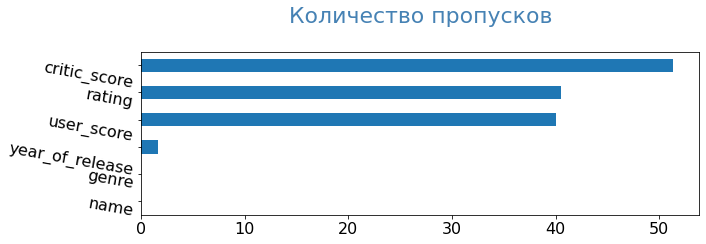

In [ ]:
pass_value_barh(df)

Строки с неизвестными названиями игр удалим. Их всего две, это не повлияет на исследование. Проверим столбец с годом выпуска

In [ ]:
df = df.dropna(subset = ['name']) # удаляем строки с неизвестными играми

In [ ]:
df['year_of_release'].unique() #определим уникальные значения по столбцу Год выпуска

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])



Чтобы поменять тип столбца на int (т.к года могут быть только целочисленными), заменим все значения nan на 0



In [ ]:
df['year_of_release'] = df['year_of_release'].fillna(0)
df['year_of_release'] = df['year_of_release'].astype(int)

Столбец user_score нужно привести к численному типу. Проверим его уникальные значения

In [ ]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Заменим значение tbd на NaN и приведем значения столбца к вещественному типу

In [ ]:
df['user_score'] = df['user_score'].replace('tbd', np.NaN)
df['user_score'] = df['user_score'].astype(float)

Пропуски в critic_score       8578, user_score         6701, rating             6766 оставим как есть. Их слишком много, удалять их нельзя, на 0 заменять тоже некорректно - это негативно повлияет на дальнейшее исследование.


In [ ]:
df['rating']= df['rating'].fillna ('unknown')


Проверим данные на дубликаты

In [ ]:
dupl = df[df.duplicated()]
dupl

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Полных дубликатов нет. Поищем неявные дубликаты

In [ ]:
df['name'].value_counts() #проверим уникальные значения названия игр

Need for Speed: Most Wanted                          12
LEGO Marvel Super Heroes                              9
Madden NFL 07                                         9
Ratatouille                                           9
FIFA 14                                               9
                                                     ..
Petz: Dogz Family                                     1
World Championship Poker: Howard Lederer - All In     1
Transformers: War for Cybertron (DS Version)          1
Godzilla: Domination!                                 1
Sumikko Gurashi: Koko ga Ochitsukundesu               1
Name: name, Length: 11559, dtype: int64

In [ ]:
df['name'].duplicated().sum() #посчитаем количество дубликатов в названиях игр

5154

Очень много строк с дубликатами по названию игры. Посмотрим, чем отличаются строки

In [ ]:
df.query('name == "Need for Speed: Most Wanted"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012,Racing,0.71,1.46,0.06,0.58,NaN,NaN,unknown
1190,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1998,Need for Speed: Most Wanted,XB,2005,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2048,Need for Speed: Most Wanted,PSV,2012,Racing,0.33,0.45,0.01,0.22,NaN,NaN,unknown
3581,Need for Speed: Most Wanted,GC,2005,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6273,Need for Speed: Most Wanted,WiiU,2013,Racing,0.13,0.12,0.00,0.02,NaN,NaN,unknown
6410,Need for Speed: Most Wanted,DS,2005,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


Видим, что название одно, а остальные данные разные. Значит мы не можем удалить эти дубликаты. По факту игры разные.

In [ ]:
df['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [ ]:
df['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

Дубликаты по жанру и рейтингу не обнаружены

### Посчитаем суммарные продажи во всех регионах

In [ ]:
df['total_sales'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
#добавим столбец с общими продажами
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


## Проведем исследовательский анализ данных

#### Исследуем сколько игр выпускалось в разные годы

In [ ]:
df['year_of_release'].describe()

count    16713.000000
mean      1974.191348
std        252.574959
min          0.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

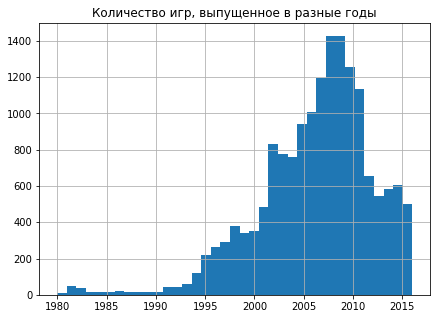

In [ ]:
df['year_of_release'].hist(bins = 37, figsize = (7,5), range = (1980,2016))
plt.title('Количество игр, выпущенное в разные годы')
plt.show()

In [ ]:
df.year_of_release.value_counts().head(36) # в порядке убывания количества продаж по годам

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
0        269
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1983      17
1989      17
1987      16
1990      16
1988      15
1984      14
Name: year_of_release, dtype: int64

По графику видим, как сильно увеличилось количество проданных игр со временем. Это связано с развитием технологий и индустрии игр. Также видно просадку продаж после 2008 года. Скорее всего это связано с мировым финансовым кризисом и его влиянием на индустрию. Хотя точно сказать мы не можем.
Этот график дает нам понять, что с 1980 по 1995 года данных критически мало.

Посчитаем количество строк и посмотрим, можно ли их исключить из исследования

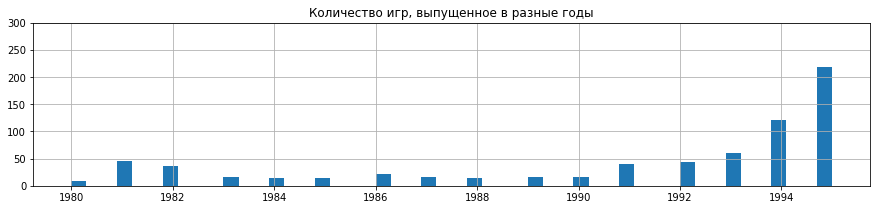

In [ ]:
df.hist(column = 'year_of_release', bins = 50, figsize = (15,3), range = (1980,1995))
plt.title('Количество игр, выпущенное в разные годы')
plt.ylim(0, 300);

In [ ]:
df[['year_of_release']].apply (['count']).style.format("{:,.2f}")# общее количество строк

,year_of_release
count,"16,713.00"


In [ ]:
df.query('year_of_release < 1995').count()
#количество строк со значением меньше 1995
# сюда же включаем проверку на 0 - это те значения NaN, которые мы поменяли.

name               755
platform           755
year_of_release    755
genre              755
na_sales           755
eu_sales           755
jp_sales           755
other_sales        755
critic_score       158
user_score         131
rating             755
total_sales        755
dtype: int64

Количество строк меньше 5%. Исключим их.

In [ ]:
df = df.loc[(df['year_of_release'] >= 1995)]
#записываем в таблицу только данные с подходящими условиями

#### Исследуем как менялись продажи по платформам

Сгруппируем данные по платформам и найдем общую сумму продаж по каждой из них
<a id=здесь></a>

In [ ]:
df_pl = df.groupby('platform')['total_sales'].sum().sort_values(ascending = False)


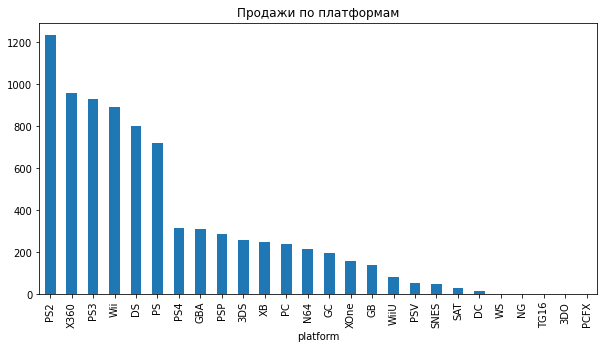

In [ ]:
df_pl.plot(kind = 'bar', figsize = (10,5), title = 'Продажи по платформам')
plt.xlabel("platform")
plt.show()


Сформируем топ 10 платформ с самыми высокими продажами

In [ ]:
df_pl = df_pl.reset_index().head(10)
df_pl

,platform,total_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.76
5,PS,721.55
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


Построим графики по каждой из этих платформ

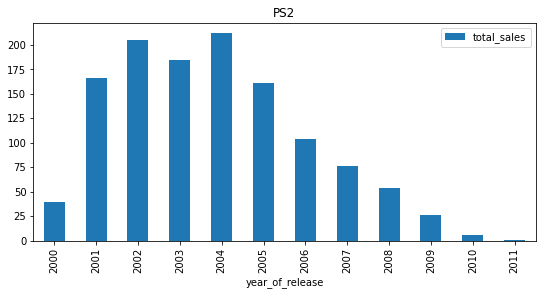

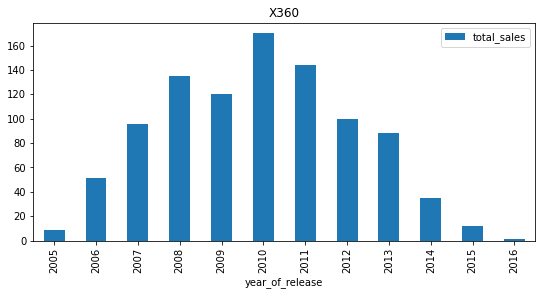

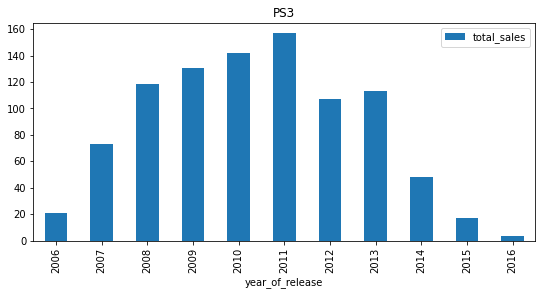

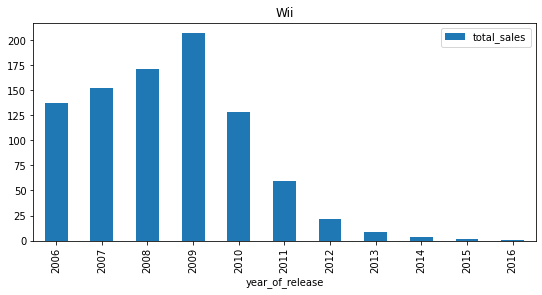

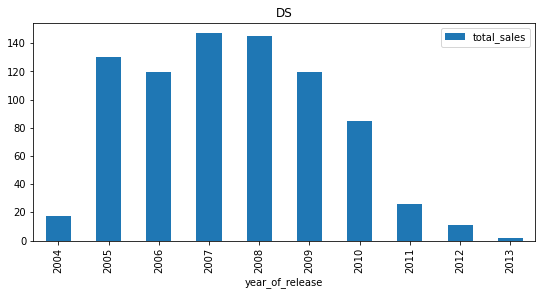

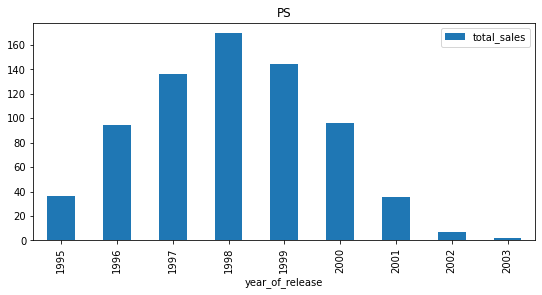

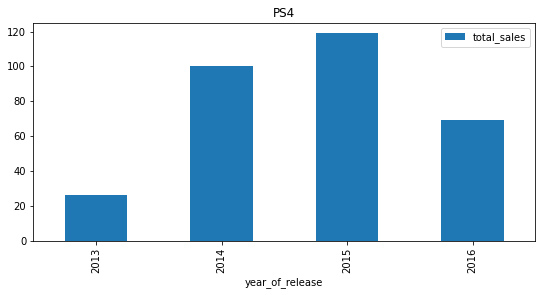

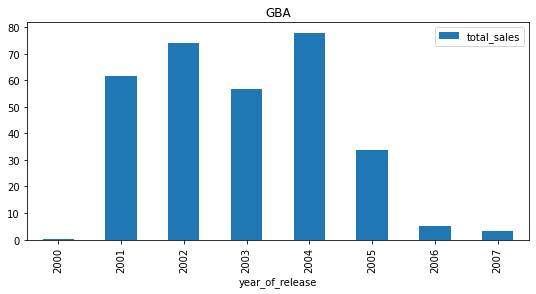

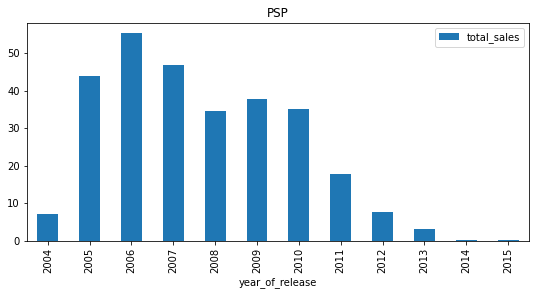

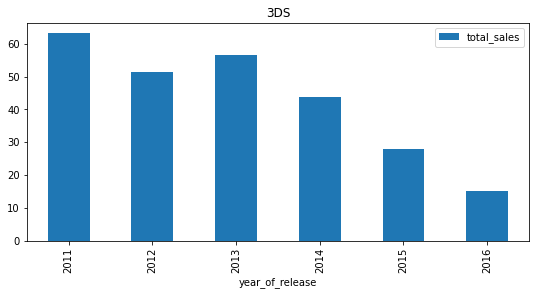

In [ ]:
for index in df_pl['platform']:
    df[df['platform'] == index].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')\
    .plot(kind='bar', figsize=(9,4))
    plt.title(index)


Чаще всего жизненный цикл платфоомы занимает около 10ти лет. При этом пик продаж случается на 3-5 год существования платформы. На основании этого возьмем последние 4 года за актуальный период.

Запишем таблицу только с актуальными данными

In [ ]:
df = df.loc[(df['year_of_release'] >= 2013)]


Выясним какие платформы лидируют по продажам

In [ ]:
df_pl = df.groupby('platform')['total_sales'].sum().sort_values(ascending = False)
df_pl = df_pl.reset_index()
df_pl

,platform,total_sales
0,PS4,314.14
1,PS3,181.43
2,XOne,159.32
3,3DS,143.25
4,X360,136.80
5,WiiU,64.63
6,PC,39.43
7,PSV,32.99
8,Wii,13.66
9,PSP,3.50


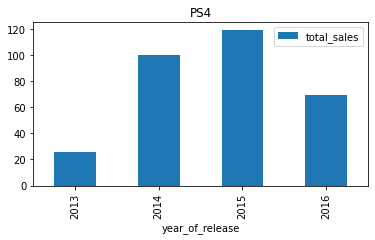

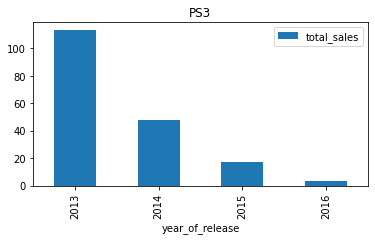

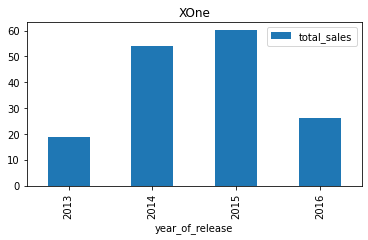

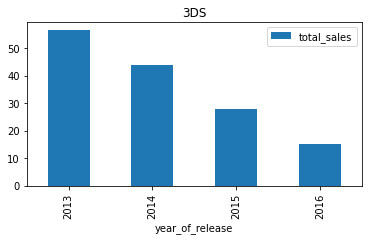

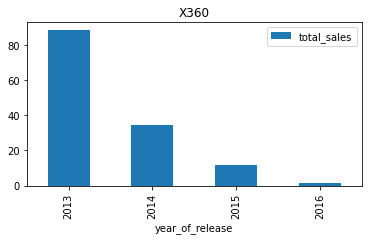

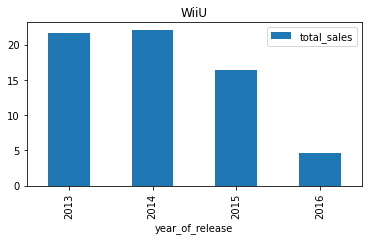

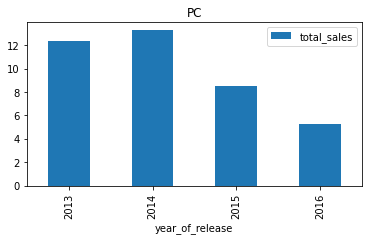

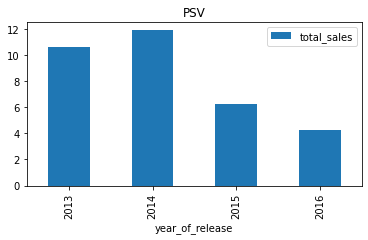

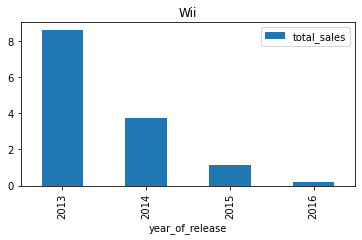

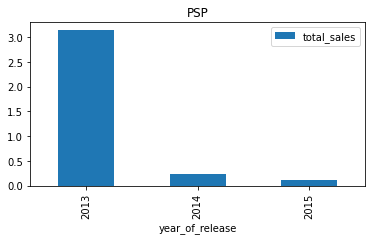

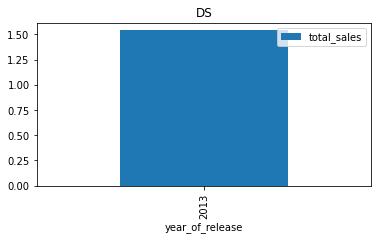

In [ ]:
for index in df_pl['platform']:
    df[df['platform'] == index].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')\
    .plot(kind='bar', figsize=(6,3))
    plt.title(index)

Кажется, что по всем платформам на данный момент продажи падают. Но нужно иметь в виду, что данные за 2016 не полные и год еще не закончен. Соответственно, данные могут измениться.  По DS у нас есть данные только за 2013 год. По PSP нет данных за 2016 год вообще. Тем не менее, если рассмотреть динамику продаж за предыдущие года, то можно выделить платформы, которые наращивают продажи - это PS4, XOne. Возьмем PC и WiiU как перспективные тоже.

#### Построим диаграмму размаха

In [ ]:
perspective = df.query('platform == "PS4" or platform == "XOne" or platform == "PC" or platform == "WiiU"')
# срез по перспективным платформам
perspective.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,943.000000,943.000000,943.000000,943.000000,943.000000,640.000000,674.000000,943.000000
mean,2014.867444,0.256819,0.252269,0.028823,0.074517,73.173438,6.608902,0.612428
std,1.018111,0.536214,0.579797,0.098201,0.178949,12.389843,1.518478,1.248627
min,2013.000000,0.000000,0.000000,0.000000,0.000000,19.000000,1.400000,0.010000
25%,2014.000000,0.000000,0.020000,0.000000,0.000000,67.000000,5.825000,0.050000
50%,2015.000000,0.060000,0.070000,0.000000,0.020000,75.000000,6.900000,0.170000
75%,2016.000000,0.250000,0.230000,0.020000,0.060000,82.000000,7.700000,0.600000
max,2016.000000,6.030000,6.310000,1.460000,2.380000,97.000000,9.300000,14.630000


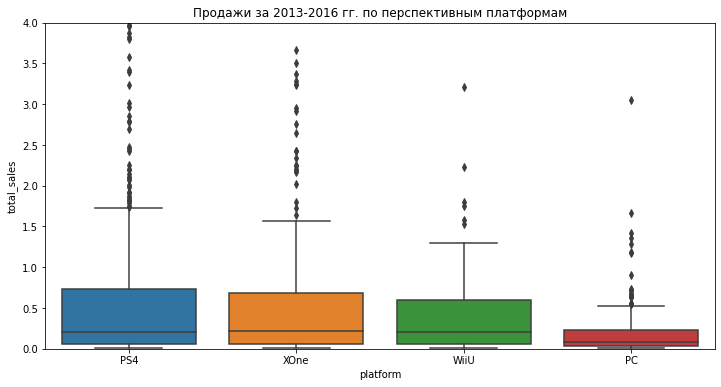

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data = perspective, x='platform', y = 'total_sales').set(ylim=(0,4))
plt.title('Продажи за 2013-2016 гг. по перспективным платформам')
plt.show()

На перспективных платформах с 2013 по 2016 гг. продавалось в основном от 0,2 до 1 млн копий игр. Минимум 10 тыс копий, максимум 12 млн. Разброс очень большой, поэтому мы видим множество точек за ""усами".

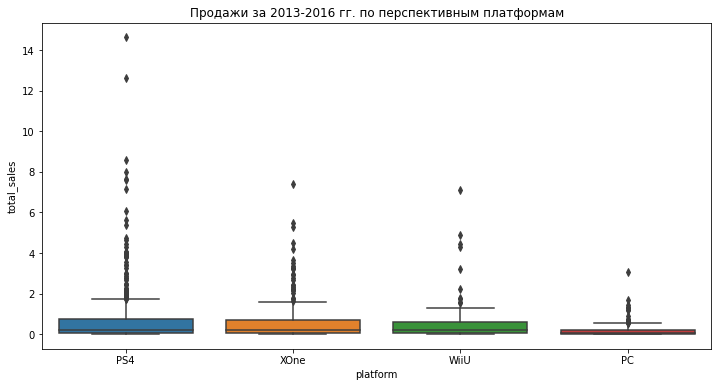

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data = perspective, x='platform', y = 'total_sales')
plt.title('Продажи за 2013-2016 гг. по перспективным платформам')
plt.show()

График без предела по оси продаж позволяет оценить разброс.

#### Рассмотрим, как влияют отзывы на продажи

Возьмем в качестве исследуемой платформу с самыми высокими продажами PS4

In [ ]:
ps4 = df.loc[(df['platform'] == 'PS4')]

In [ ]:
print('Коэффициент корреляции продаж и отзывов критиков', ps4['critic_score'].corr(ps4['total_sales']))

Коэффициент корреляции продаж и отзывов критиков 0.40656790206178095


Корреляция низкая, зависимость от отзывов критиков слабая.

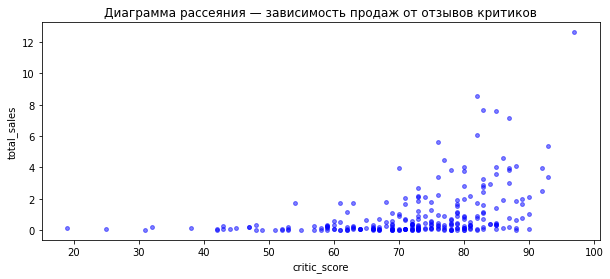

In [ ]:
ps4.plot(kind='scatter',
        y='total_sales' , x='critic_score', alpha=0.5, subplots=True, figsize=(10,4), c = 'b', s = 15)
plt.title('Диаграмма рассеяния — зависимость продаж от отзывов критиков')
plt.show()

Большая часть критиков ставила оценки от 60 до 80 баллов. Опираясь на диаграмму рассеяния, можем сказать о существующей, но слабой зависимости количества продаж от отзывов критиков.

In [ ]:
print('Коэффициент корреляции продаж и отзывов пользователей по платформе PS4',ps4['user_score'].corr(ps4['total_sales']))

Коэффициент корреляции продаж и отзывов пользователей по платформе PS4 -0.031957110204556376


Корреляция очень слабая

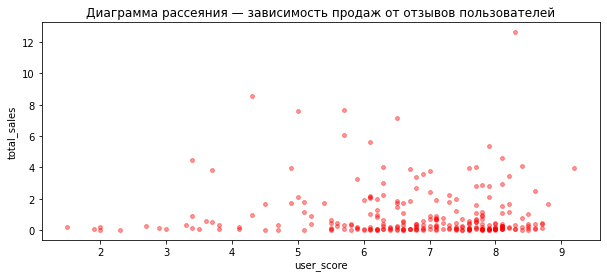

In [ ]:
ps4.plot(kind='scatter',
        y='total_sales' , x='user_score', alpha=0.4, subplots=True, figsize=(10,4), c = 'r', s = 15)
plt.title('Диаграмма рассеяния — зависимость продаж от отзывов пользователей')
plt.show()

Большая часть игр получавет оценку пользователя от 6 до 8 баллов. Как мы видим по корреляции и графику, зависимость продаж от оценок пользователей настолько мала, что несущественна.

#### Сравним с общей картиной в мире

In [ ]:
print('Коэффициент корреляции продаж и отзывов критиков', df['critic_score'].corr(df['total_sales']))

Коэффициент корреляции продаж и отзывов критиков 0.3136995151027371


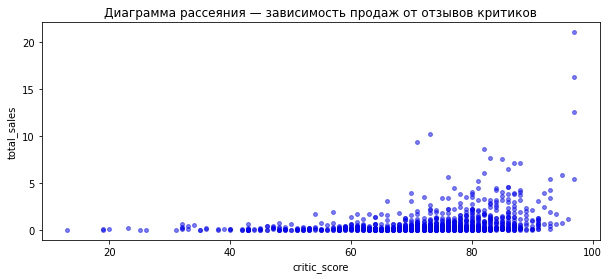

In [ ]:
df.plot(kind='scatter',
        y='total_sales' , x='critic_score', alpha=0.5, subplots=True, figsize=(10,4), c = 'b', s = 15)
plt.title('Диаграмма рассеяния — зависимость продаж от отзывов критиков')
plt.show()

In [ ]:
print('Коэффициент корреляции продаж и отзывов пользователей',df['user_score'].corr(df['total_sales']))

Коэффициент корреляции продаж и отзывов пользователей -0.0026078133545982744


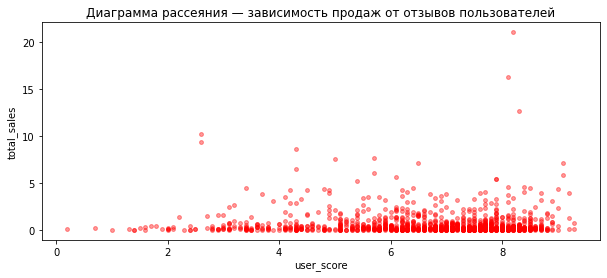

In [ ]:
df.plot(kind='scatter',
        y='total_sales' , x='user_score', alpha=0.4, subplots=True, figsize=(10,4), c = 'r', s = 15)
plt.title('Диаграмма рассеяния — зависимость продаж от отзывов пользователей')
plt.show()

Если сравнить с корреляцией продаж и отзывов по каждой отдельной игре, выводы останутся прежними.

#### Сравним с продажами игр на других платформах

Возьмем перспективную XOne и 2 платформы из начала списка с высокими продажами . Это PS3 и 3DS

In [ ]:
xone = df.query('platform == "XOne"')
ps3 = df.query('platform == "PS3"')
ds3 = df.query('platform == "3DS"')

In [ ]:
print('Коэффициент корреляции продаж и отзывов критиков по платформе XOne', xone['total_sales'].corr(xone['critic_score']))


Коэффициент корреляции продаж и отзывов критиков по платформе XOne 0.41699832800840175


In [ ]:
print('Коэффициент корреляции продаж и отзывов критиков по платформе PS3', ps3['total_sales'].corr(ps3['critic_score']))

Коэффициент корреляции продаж и отзывов критиков по платформе PS3 0.3342853393371919


In [ ]:
print('Коэффициент корреляции продаж и отзывов критиков по платформе 3DS', ds3['total_sales'].corr(ds3['critic_score']))

Коэффициент корреляции продаж и отзывов критиков по платформе 3DS 0.35705661422881035


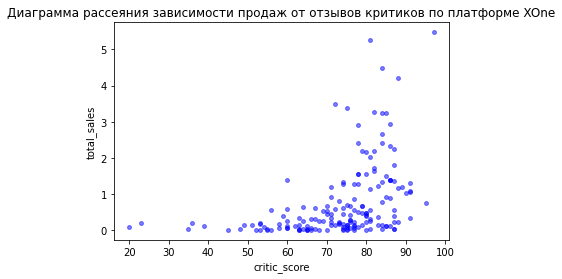

In [ ]:
xone.plot(kind='scatter', y='total_sales' , x='critic_score', alpha=0.5, subplots=True, figsize=(6,4), c = 'b', s = 15)
plt.title('Диаграмма рассеяния зависимости продаж от отзывов критиков по платформе XOne')
plt.show()

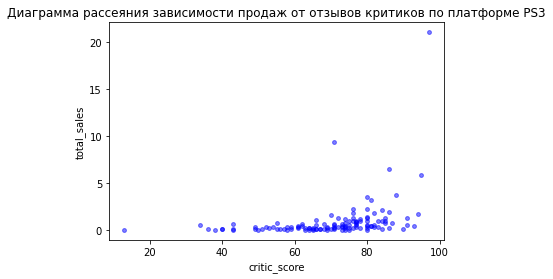

In [ ]:
ps3.plot(kind='scatter', y='total_sales' , x='critic_score', alpha=0.5, subplots=True, figsize=(6,4), c = 'b', s = 15)
plt.title('Диаграмма рассеяния зависимости продаж от отзывов критиков по платформе PS3')
plt.show()

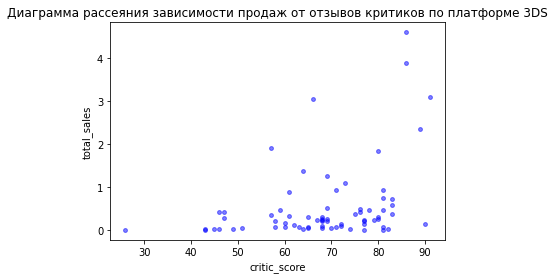

In [ ]:
ds3.plot(kind='scatter', y='total_sales' , x='critic_score', alpha=0.5, subplots=True, figsize=(6,4), c = 'b', s = 15)
plt.title('Диаграмма рассеяния зависимости продаж от отзывов критиков по платформе 3DS')
plt.show()

Видим, что зависимость продаж от отзывов критиков примерно одинакова и не превышает 41%. Это совпадает с предыдущими результатами. И говорит о том, что критики не сильно влияют на продажи.

In [ ]:
print('Коэффициент корреляции продаж и отзывов пользователей по платформе XOne', xone['total_sales'].corr(xone['user_score']))

Коэффициент корреляции продаж и отзывов пользователей по платформе XOne -0.06892505328279412


In [ ]:
print('Коэффициент корреляции продаж и отзывов пользователей по платформе PS3',ps3['total_sales'].corr(ps3['user_score']))

Коэффициент корреляции продаж и отзывов пользователей по платформе PS3 0.0023944027357566925


In [ ]:
print('Коэффициент корреляции продаж и отзывов пользователей по платформе 3DS', ds3['total_sales'].corr(ds3['user_score']))

Коэффициент корреляции продаж и отзывов пользователей по платформе 3DS 0.24150411773563016


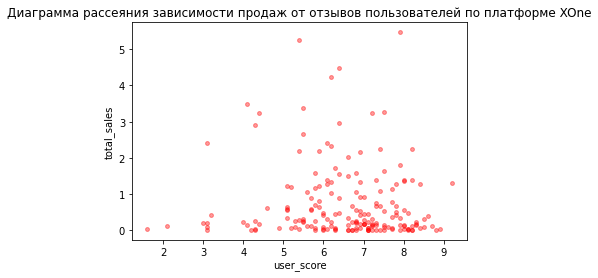

In [ ]:
xone.plot(kind='scatter', y='total_sales' , x='user_score', alpha=0.4, subplots=True, figsize=(6,4), c = 'r', s = 15)
plt.title('Диаграмма рассеяния зависимости продаж от отзывов пользователей по платформе XOne')
plt.show()

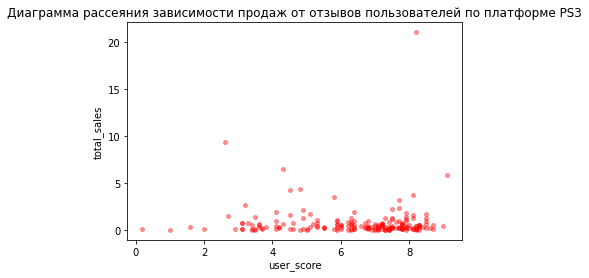

In [ ]:
ps3.plot(kind='scatter', y='total_sales' , x='user_score', alpha=0.4, subplots=True, figsize=(6,4), c = 'r', s = 15)
plt.title('Диаграмма рассеяния зависимости продаж от отзывов пользователей по платформе PS3')
plt.show()

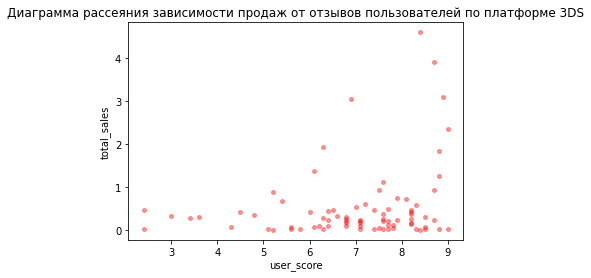

In [ ]:
ds3.plot(kind='scatter', y='total_sales' , x='user_score', alpha=0.4, subplots=True, figsize=(6,4), c = 'r', s = 15)
plt.title('Диаграмма рассеяния зависимости продаж от отзывов пользователей по платформе 3DS')
plt.show()

Построенные графики и значения корреляции подтверждают предыдущие выводы. Только зависимость продаж от отзывов пользователей игр 3DS неожиданно выше других. Но она все еще низкая, чтобы быть существенной.

#### Распределение игр по жанрам

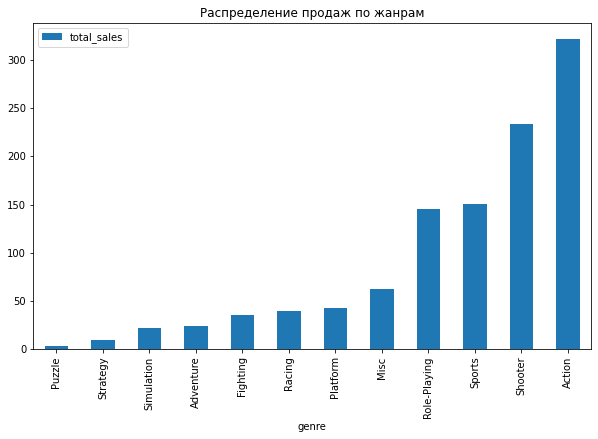

In [ ]:
df.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'sum').sort_values('total_sales').plot(kind = 'bar', figsize = (10,6))
plt.title('Распределение продаж по жанрам')
plt.show()

Распределив игры по жанрам, можно увидеть, что самые популярные жанры - это экшн, шутеры и спортивные. Самые непопулярные - пазлы, стратегии, симуляторы

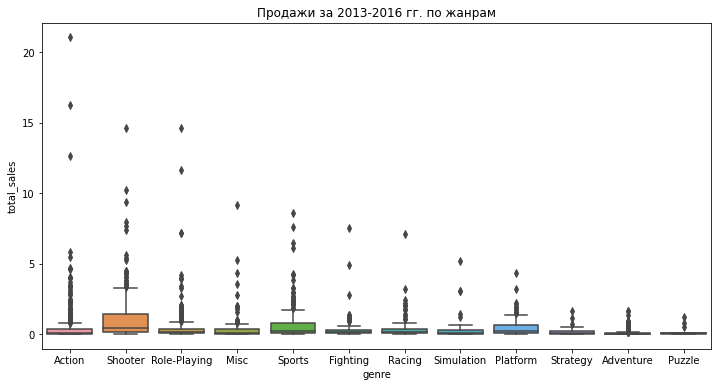

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data = df, x='genre', y = 'total_sales')
plt.title('Продажи за 2013-2016 гг. по жанрам')
plt.show()

Рассмотрим поближе

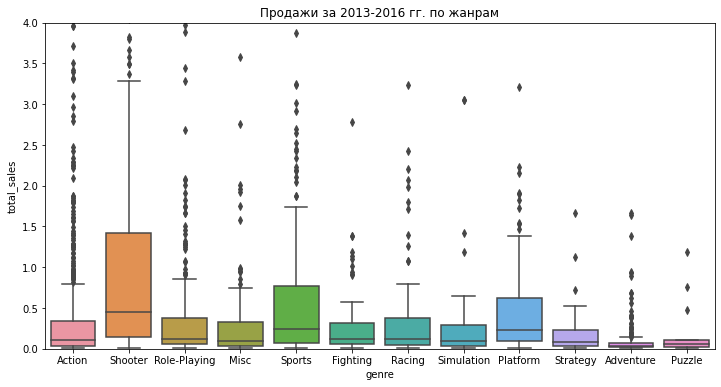

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data = df, x='genre', y = 'total_sales').set(ylim=(0,4))
plt.title('Продажи за 2013-2016 гг. по жанрам')
plt.show()

Медианы продаж шутеров и спортивных игр выше остальных. Эти жанры самые перспективные. Остальные медианы примерно на одном уровне. Интересно, что несмотря на самые высокие продажи в жанре экшн, его медиана намного ниже шутеров. Это говорит о том, что есть значения очень высоких продаж экшн игр, которые на графике попадают в выбросы. Они как бы компенсируют большее количество непопулярных игр в жанре.

## Портрет пользователя каждого региона

#### Самые популярные платформы для каждого региона

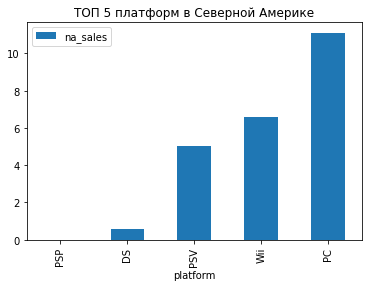

In [ ]:
df_na = df.pivot_table(index = 'platform', values = 'na_sales', aggfunc = 'sum')\
.sort_values('na_sales').head(5)
df_na.plot(kind = 'bar', figsize=(6,4))
plt.title('ТОП 5 платформ в Северной Америке')
plt.show()

В Северной Америке самые популярные платформы PC, Wii, PSV

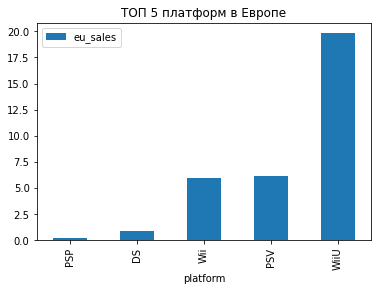

In [ ]:
df_eu = df.pivot_table(index = 'platform', values = 'eu_sales', aggfunc = 'sum')\
.sort_values('eu_sales').head(5)
df_eu.plot(kind = 'bar', figsize=(6,4))
plt.title('ТОП 5 платформ в Европе')
plt.show()

В Европе самые популярные платформы WiiU, PSV, Wii

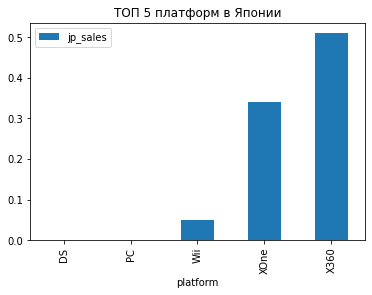

In [ ]:
df_jp = df.pivot_table(index = 'platform', values = 'jp_sales', aggfunc = 'sum')\
.sort_values('jp_sales').head(5)
df_jp.plot(kind = 'bar', figsize=(6,4))
plt.title('ТОП 5 платформ в Японии')
plt.show()

В Японии самые популярные платформы X360, XOne, Wii.

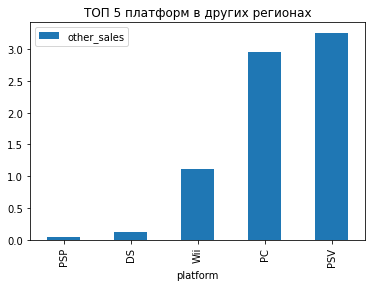

In [ ]:
df_oth = df.pivot_table(index = 'platform', values = 'other_sales', aggfunc = 'sum')\
.sort_values('other_sales').head(5)
df_oth.plot(kind = 'bar', figsize=(6,4))
plt.title('ТОП 5 платформ в других регионах')
plt.show()

Первое, что может броситься в глаза, — то, что доля пользователей, играющих на игровых консолях, больше, чем доля играющих на ПК везде, кроме Северной Америки.

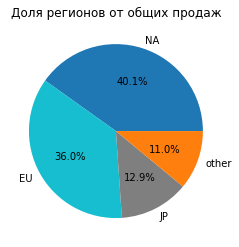

In [ ]:
na_part = df['na_sales'].sum()/df['total_sales'].sum()
eu_part = df['eu_sales'].sum()/df['total_sales'].sum()
jp_part = df['jp_sales'].sum()/df['total_sales'].sum()
oth_part = df['other_sales'].sum()/df['total_sales'].sum()
x= [na_part, eu_part, jp_part, oth_part]

labels = ['NA', 'EU', 'JP', 'other']
colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange']

fig, ax = plt.subplots()
ax.pie(x, labels = labels, colors = colors, autopct='%1.1f%%')
ax.set_title('Доля регионов от общих продаж')
plt.show()

Самая высокая доля продаж в Северной Америке 40.1%. В Европе 36%. В Японии 12.9%. И на долю других регионов приходится 11% всех продаж.  

#### Самые популярные жанры для каждого региона

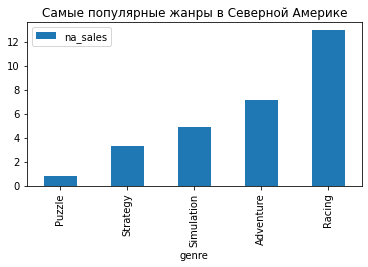

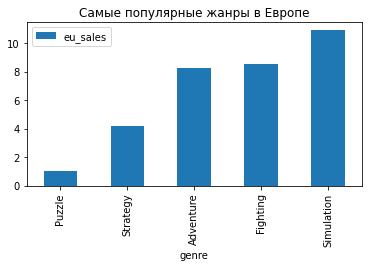

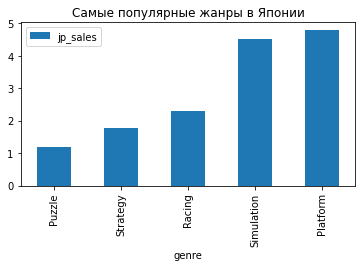

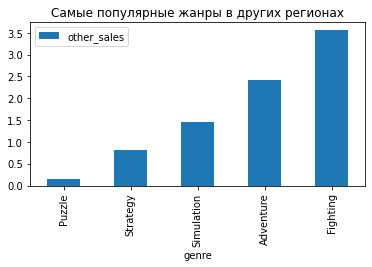

In [ ]:
df_na = df.pivot_table(index = 'genre', values = 'na_sales', aggfunc = 'sum')\
.sort_values('na_sales').head(5)
df_na.plot(kind = 'bar', figsize=(6,3), title= 'Самые популярные жанры в Северной Америке')
plt.show() #Группируем данные по жанру и региону, строим график

df_eu = df.pivot_table(index = 'genre', values = 'eu_sales', aggfunc = 'sum')\
.sort_values('eu_sales').head(5)
df_eu.plot(kind = 'bar', figsize=(6,3), title= 'Самые популярные жанры в Европе')
plt.show()#Группируем данные по жанру и региону, строим график

df_jp = df.pivot_table(index = 'genre', values = 'jp_sales', aggfunc = 'sum')\
.sort_values('jp_sales').head(5)
df_jp.plot(kind = 'bar', figsize=(6,3), title= 'Самые популярные жанры в Японии')
plt.show()#Группируем данные по жанру и региону, строим график

df_oth = df.pivot_table(index = 'genre', values = 'other_sales', aggfunc = 'sum')\
.sort_values('other_sales').head(5)
df_oth.plot(kind = 'bar', figsize=(6,3), title= 'Самые популярные жанры в других регионах')
plt.show()#Группируем данные по жанру и региону, строим график

По графикам видим, что в каждом регионе свои лидеры. В Северной Америке популярны игры жанров racing и adventure. В Европе это simulation и fighting. В Японии platform и simulation. В других регионах fighting  и  adventure. В связи с такой разницей, мы можем сказать, что выбор жанра зависит от социальных и культурных аспектов региона и на него влияет большое количество факторов: концепция, опыт, обстановка, личностный тип игрока и др. Но это тема для отдельного исследования.

#### Влияние рейтинга ESRB на продажи

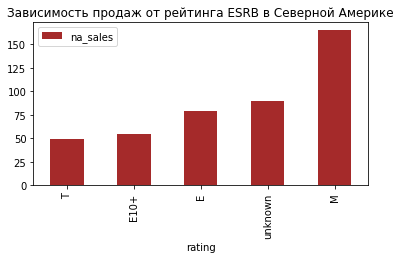

In [ ]:
df_na = df.pivot_table(index = 'rating', values = 'na_sales', aggfunc = 'sum')\
.sort_values('na_sales').head(5)
df_na.plot(kind = 'bar', figsize=(6,3), color = 'brown',  title= 'Зависимость продаж от рейтинга ESRB в Северной Америке')
plt.show() #Группируем данные по рейтингу и региону, строим график

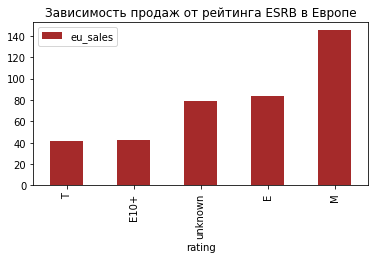

In [ ]:
df_eu = df.pivot_table(index = 'rating', values = 'eu_sales', aggfunc = 'sum')\
.sort_values('eu_sales').head(5)
df_eu.plot(kind = 'bar', figsize=(6,3), color = 'brown', title= 'Зависимость продаж от рейтинга ESRB в Европе')
plt.show()#Группируем данные по рейтингу и региону, строим график


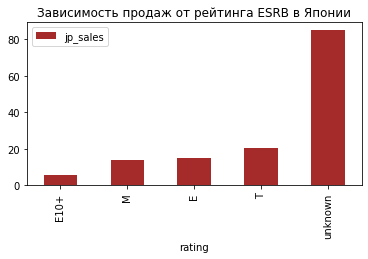

In [ ]:
df_jp = df.pivot_table(index = 'rating', values = 'jp_sales', aggfunc = 'sum')\
.sort_values('jp_sales').head(5)
df_jp.plot(kind = 'bar', figsize=(6,3), color = 'brown', title= 'Зависимость продаж от рейтинга ESRB в Японии')
plt.show()#Группируем данные по рейтингу и региону, строим график


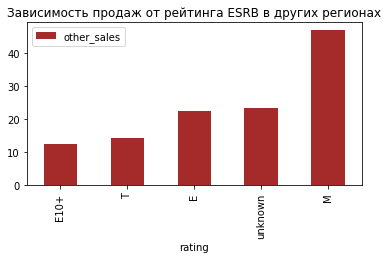

In [ ]:
df_oth = df.pivot_table(index = 'rating', values = 'other_sales', aggfunc = 'sum')\
.sort_values('other_sales').head(5)
df_oth.plot(kind = 'bar', figsize=(6,3), color = 'brown',title= 'Зависимость продаж от рейтинга ESRB в других регионах')
plt.show()#Группируем данные по рейтингу и региону, строим график

В Японии самые высокие продажи имеют игры без рейтига. Можем предположить, что японцы не часто пользуются американской рейтинговой моделью ESRB, а используют свою систему возрастного рейтинга японскую CERO.  
В остальных регионах игры для взрослой аудитории. В целом игры без рейтинга очень популярны и занимают 2,3 позиции по продажам.

Посмотрим сводную таблицу по регионам

In [ ]:
rating = df.pivot_table(index = 'rating', values = ['eu_sales','jp_sales','na_sales'], aggfunc = 'sum')
rating

,eu_sales,jp_sales,na_sales
rating,,,
E,83.36,15.14,79.05
E10+,42.69,5.89,54.24
M,145.32,14.11,165.21
T,41.95,20.59,49.79
unknown,78.91,85.05,89.42


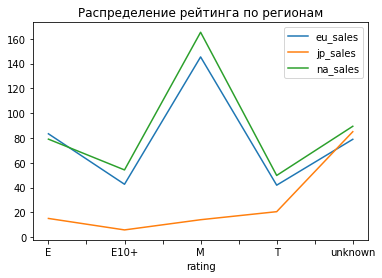

In [ ]:
rating.plot()
plt.title('Распределение рейтинга по регионам')
plt.show()

По графику хорошо видно сильную разницу в продажах игр с разным рейтингом. Для Японии этот разрыв не так очевиден, линяя более сглаженная.

## Проверим гипотезы

#### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза H₀ - **Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

Исходя из H₀ сформулируем альтернативную гипотезу H₁. Это утверждение, которое принимем верным, если отбросим H₀.

Альтернативная гипотеза H₁ - **Средние пользовательские рейтинги платформ Xbox One и PC разные**


In [ ]:
df = df.dropna(subset = ['user_score']) # избавимся от пропусков

In [ ]:
xone = df[(df['platform'] == 'XOne')]['user_score'] # оценки пользователей по платформе XOne
pc= df[(df['platform'] == 'PC')]['user_score'] # оценки пользователей по платформе PC
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(
    xone,
    pc,
    equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


Для подсчета мы используем специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind (array1, array2, equal_var)

[Ранее](#здесь) мы уже рассматриваливали продажи в разрезе платформ и видели, что количество пользователей PC и XOne разное, поэтому поставили параметру equal_var значение False

В данном случае нулевую гипотезу не получилось отвергнуть. Это значит, что значения среднего пользовательского рейтинга скорее всего равны, либо очень близки по значению.

#### Средние пользовательские рейтинги жанров action и sports разные

Нулевая гипотеза H₀ - **Средние пользовательские рейтинги жанров action и sports одинаковые**

Исходя из H₀ сформулируем альтернативную гипотезу H₁. Это утверждение, которое принимем верным, если отбросим H₀.

Альтернативная гипотеза H₁ - **Средние пользовательские рейтинги жанров action и sports разные**

In [ ]:
action = df[(df['genre'] == 'Action')]['user_score'] # оценки пользователей по платформе XOne
sports= df[(df['genre'] == 'Sports')]['user_score'] # оценки пользователей по платформе PC
alpha = .001 # критический уровень статистической значимости

results = st.ttest_ind(
    action,
    sports,
    equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


Для подсчета мы используем тот же метод, т.к снова проверяем гипотезу о равенстве среднего двух генеральных совокупностей.
Здесь мы можем отвергнуть нулевую гипотезу и принять альтернативную, что средние пользовательские рейтинги разные.

## Общий вывод

**Мы выяснили:**
>-Развитие технологий и индустрии игр происходило с феноменальной скоростью. Жизненный цикл платформ примерно 10 лет, пик популярности приходится на 3-5 год.

>-ТОП 5 платформ по продажам за все годы PS2	1255.77, X360 971.42, PS3 939.65, Wii 907.51,DS	806.10 млн. копий

>-Зависимость продаж от отзывов критиков есть, но слабая.

>-Зависимость продаж от пользовательских рейтингов не подтвердилась

>-Самые популярные жанры - это экшн, шутеры и спортивные. Самые непопулярные - пазлы, стратегии, симуляторы

>-Самые перспективные жанры - это шутеры и спортивные игры.

>-Популярность платформ и жанров сильно отличается в зависимости от региона

>-В Северной Америке популярны игры жанров racing и adventure. В Европе это simulation и fighting. В Японии platform и simulation. В других регионах fighting  и  adventure. В связи с такой разницей, мы можем сказать, что выбор жанра зависит от социальных и культурных аспектов региона

>-В Японии лидером продаж являются игры без рейтинга ESRB. В остальных регионах игры для взрослой аудитории
